In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteMY1HO7/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteMY1HO7/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteMY1HO7/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy()[:50])
    print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lu"
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print('labels: ', label.numpy()[:3])

texts:  [b'Antonioni was aiming for another hip masterpiece, this time on the other side of the Atlantic than "Blow up". It wasn\xc2\xb4t the success with critics and youth like the former though. Why? Maybe because it was a European\xc2\xb4s view of America filled with clich\xc3\xa9s that didn\xc2\xb4t work then and that have not aged well. (The revolutionary students at the beginning is embarrassing.)<br /><br />Maybe when it was released big blockbuster movies and those aimed specifically at the youth market seemed dated. If it had been released a year before maybe hippes in deserts would have seemed fresh... It\xc2\xb4s a very interesting film tho, very beautifully shot with some brilliant and Antonionian scenes in between, like the love-making in the desert, the stillness of the desert mansion and the explosive ending... That the leads were two amateurs didn\xc2\xb4t help. They were beautiful but inexperienced. Mark Freshette is slightly better than Daria Halprin. It would have be

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
example = "This was an absolutely terrible movie."
encoded_example = encoder(example).numpy()
print(encoded_example)
print([vocab[idx] for idx in encoded_example])

[ 11  14  34 412 384  18]
['this', 'was', 'an', 'absolutely', 'terrible', 'movie']


In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64, mask_zero=True),
    tf.keras.layers.LSTM(96),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.01834409]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.01834408]


In [ ]:
model.layers

In [ ]:
embedding_model = tf.keras.Model(model.input, model.layers[1].output)

In [ ]:
embedding_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_input (I  [(None,)]                0         
 nputLayer)                                                      
                                                                 
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
Total params: 64,000
Trainable params: 64,000
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model = tf.keras.Model(model.input, model.layers[2].output)

In [ ]:
lstm_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_input (I  [(None,)]                0         
 nputLayer)                                                      
                                                                 
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 lstm (LSTM)                 (None, 96)                61824     
                                                                 
Total params: 125,824
Trainable params: 125,824
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 lstm (LSTM)                 (None, 96)                61824     
                                                                 
 dense (Dense)               (None, 64)                6208      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 132,097
Trainable params: 132,097
Non-trainable params: 0
__________________________________________________

In [ ]:
input_example = np.array([example])
print(input_example)
print(input_example.shape)
encoded = encoder(input_example)
print(encoded)
print(encoded.shape)
embedding_output = embedding_model(input_example)
print(embedding_output.shape)

lstm_output = lstm_model(input_example)
print(lstm_output)
print(lstm_output.shape)

['This was an absolutely terrible movie.']
(1,)
tf.Tensor([[ 11  14  34 412 384  18]], shape=(1, 6), dtype=int64)
(1, 6)
(1, 6, 64)
tf.Tensor(
[[-3.2017170e-03  3.2005375e-03 -5.2800891e-03 -1.1208845e-02
   5.3439899e-03 -1.0961223e-02  4.9632373e-03  1.2330371e-02
   1.0036396e-02 -4.1106655e-03 -8.8370293e-03 -7.9354867e-03
  -1.0167811e-02  7.2847600e-03  2.7348017e-03 -5.1686610e-03
  -3.6961571e-03 -3.2102026e-03  8.4187184e-03  6.1968868e-03
  -2.3563113e-03  5.0624954e-03 -9.2912810e-03  1.1034763e-02
   5.8892546e-03 -1.4494265e-03 -3.3936924e-03 -4.5537092e-03
  -1.9037274e-04 -8.9538479e-03 -2.7041298e-03  2.4107394e-03
   1.3953961e-03  6.8683983e-03 -8.0304723e-03 -8.3136477e-04
  -9.9706324e-04  6.6346042e-03  1.7338180e-03  2.3238435e-03
   1.8511588e-03 -9.6107768e-03 -1.1520589e-02  5.0938141e-04
  -5.5187277e-04 -1.6424551e-03  3.7040585e-03 -6.1787805e-03
   1.6112762e-03 -5.1398855e-03 -2.1841251e-03 -7.1649387e-04
  -1.1888536e-02 -3.8229916e-03 -6.3031982e-03 -6.6

In [ ]:
input_example = np.array(["This was an absolutely terrible movie."])
lstm_output = lstm_model(input_example)
print(lstm_output[0, :4])
print(lstm_output.shape)

tf.Tensor([-0.00320172  0.00320054 -0.00528009 -0.01120885], shape=(4,), dtype=float32)
(1, 96)


In [ ]:
input_example = np.array(["movie terrible absolutely an was This."])
lstm_output = lstm_model(input_example)
print(lstm_output[0, :4])
print(lstm_output.shape)

tf.Tensor([-0.00748638 -0.00060623 -0.00187602 -0.00716687], shape=(4,), dtype=float32)
(1, 96)


In [ ]:
input_example = np.array([example])
print(input_example)
print(input_example.shape)
encoded = encoder(input_example)
print(encoded)
print(encoded.shape)
embedding_output = embedding_model(input_example)
print(embedding_output.shape)
embedding_output = embedding_model(input_example)
print(embedding_output.shape)

In [ ]:
input_example = np.array([sample_text])
print(input_example)
print(input_example.shape)
encoded = encoder(input_example)
print(encoded)
print(encoded.shape)
embedding_output = embedding_model(input_example)
print(embedding_output)
print(embedding_output.shape)

['The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.']
(1,)
tf.Tensor(
[[  2  18  14 652   2 737   3   2   1  66  46   5  11 188  10  59 368  11
   18]], shape=(1, 19), dtype=int64)
(1, 19)
tf.Tensor(
[[[ 0.04075588 -0.02038342  0.04921978 ...  0.02944917 -0.04936588
    0.03717358]
  [-0.0266315  -0.01445341 -0.00967784 ...  0.04084805 -0.02211556
   -0.01313853]
  [-0.00536951  0.02430077  0.0127377  ...  0.03972617  0.04288128
   -0.03595077]
  ...
  [-0.00623537  0.03152077 -0.02652838 ... -0.02869689 -0.00464189
    0.04370178]
  [ 0.01814276  0.03868649  0.04177869 ... -0.04134747  0.03214027
   -0.02303604]
  [-0.0266315  -0.01445341 -0.00967784 ...  0.04084805 -0.02211556
   -0.01313853]]], shape=(1, 19, 64), dtype=float32)
(1, 19, 64)


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 27s 53ms/step - loss: 0.6300 - accuracy: 0.5808 - val_loss: 0.4747 - val_accuracy: 0.7823
Epoch 2/10
391/391 [==============================] - 20s 51ms/step - loss: 0.4046 - accuracy: 0.8222 - val_loss: 0.3696 - val_accuracy: 0.8438
Epoch 3/10
391/391 [==============================] - 20s 51ms/step - loss: 0.3438 - accuracy: 0.8523 - val_loss: 0.3543 - val_accuracy: 0.8349
Epoch 4/10
391/391 [==============================] - 20s 51ms/step - loss: 0.3272 - accuracy: 0.8613 - val_loss: 0.3351 - val_accuracy: 0.8609
Epoch 5/10
391/391 [==============================] - 20s 51ms/step - loss: 0.3177 - accuracy: 0.8672 - val_loss: 0.3267 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 20s 51ms/step - loss: 0.3129 - accuracy: 0.8690 - val_loss: 0.3250 - val_accuracy: 0.8615
Epoch 7/10
391/391 [==============================] - 20s 51ms/step - loss: 0.3102 - accuracy: 0.8698 - val_loss: 0.3266 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 28ms/step - loss: 0.3578 - accuracy: 0.8576
Test Loss: 0.35783451795578003
Test Accuracy: 0.8576400279998779


(0.0, 0.6463360786437988)

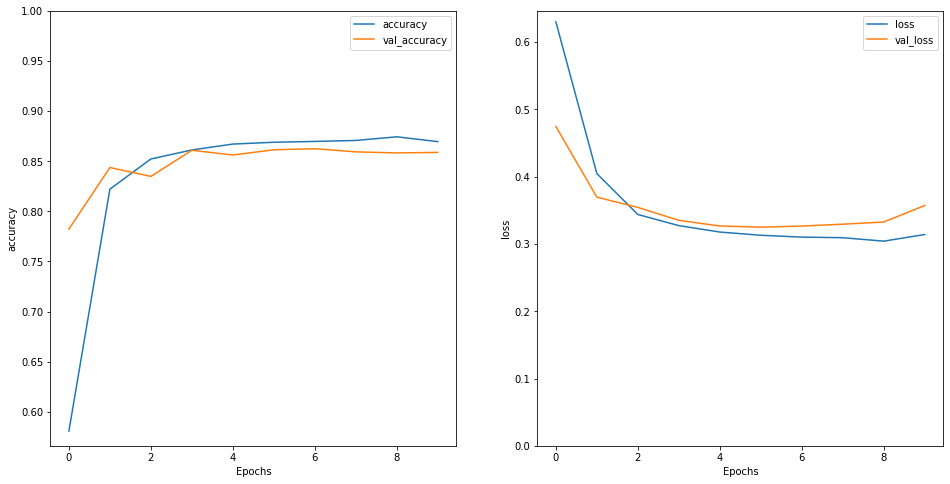

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 192)              123648    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                12352     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 200,065
Trainable params: 200,065
Non-tr

In [ ]:
lstm_model = tf.keras.Model(model.input, model.layers[2].output)

In [ ]:
input_example = np.array(["This was an absolutely terrible movie."])
lstm_output = lstm_model(input_example)
print(lstm_output[0, :4])
print(lstm_output.shape)

tf.Tensor([ 0.00225354 -0.00528568 -0.00503788  0.01122712], shape=(4,), dtype=float32)
(1, 192)


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 46s 98ms/step - loss: 0.6356 - accuracy: 0.5710 - val_loss: 0.4691 - val_accuracy: 0.7651
Epoch 2/10
391/391 [==============================] - 36s 92ms/step - loss: 0.4226 - accuracy: 0.7906 - val_loss: 0.3885 - val_accuracy: 0.8115
Epoch 3/10
391/391 [==============================] - 36s 91ms/step - loss: 0.3474 - accuracy: 0.8476 - val_loss: 0.3443 - val_accuracy: 0.8495
Epoch 4/10
391/391 [==============================] - 36s 92ms/step - loss: 0.3243 - accuracy: 0.8583 - val_loss: 0.3357 - val_accuracy: 0.8500
Epoch 5/10
391/391 [==============================] - 36s 92ms/step - loss: 0.3145 - accuracy: 0.8628 - val_loss: 0.3266 - val_accuracy: 0.8604
Epoch 6/10
391/391 [==============================] - 36s 92ms/step - loss: 0.3092 - accuracy: 0.8656 - val_loss: 0.3237 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 36s 92ms/step - loss: 0.3074 - accuracy: 0.8672 - val_loss: 0.3265 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 49ms/step - loss: 0.3185 - accuracy: 0.8568
Test Loss: 0.31852924823760986
Test Accuracy: 0.8568400144577026


더 많은 LSTM을 쌓자!!

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_10 (Embedding)    (None, None, 64)          64000     
                                                                 
 bidirectional_16 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 64)                4160      
                                                     

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 197s 452ms/step - loss: 0.6319 - accuracy: 0.5770 - val_loss: 0.4770 - val_accuracy: 0.7396
Epoch 2/10
391/391 [==============================] - 170s 432ms/step - loss: 0.4037 - accuracy: 0.8218 - val_loss: 0.3612 - val_accuracy: 0.8453
Epoch 3/10
391/391 [==============================] - 170s 431ms/step - loss: 0.3509 - accuracy: 0.8516 - val_loss: 0.3402 - val_accuracy: 0.8479
Epoch 4/10
391/391 [==============================] - 167s 425ms/step - loss: 0.3266 - accuracy: 0.8621 - val_loss: 0.3375 - val_accuracy: 0.8620
Epoch 5/10
391/391 [==============================] - 168s 428ms/step - loss: 0.3168 - accuracy: 0.8666 - val_loss: 0.3318 - val_accuracy: 0.8609
Epoch 6/10
387/391 [============================>.] - ETA: 1s - loss: 0.3120 - accuracy: 0.8698

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 81s 207ms/step - loss: 0.3171 - accuracy: 0.8621
Test Loss: 0.31714650988578796
Test Accuracy: 0.8620799779891968


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-2.0059245]]


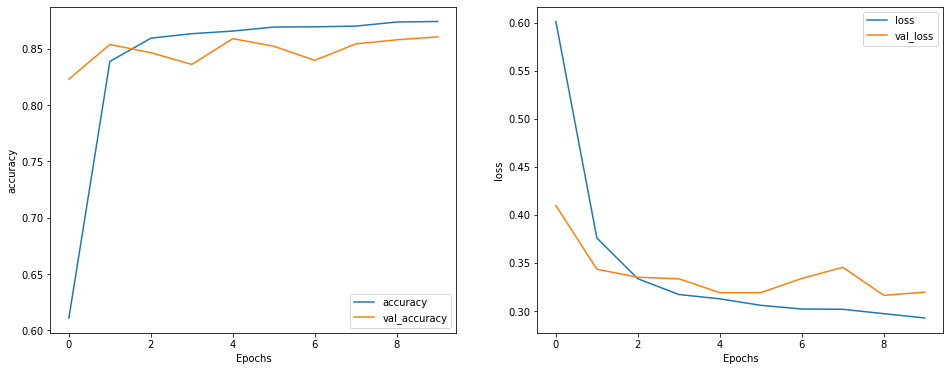

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')